In [1]:
import glob
import pandas as pd
import numpy as np
import json
import pickle
from bson.binary import Binary
from pymongo import MongoClient
import certifi
from ast import literal_eval

from pymatgen.core import Lattice, Structure
from crystal_out import crystalOut

# Uploading to mongodb in Orion

In [ ]:
mc = MongoClient(host="orion.nus.edu.sg",username="raman_ml",password="ch4ndr4s3kh4r4")
db = mc["raman_ml"]
db

In [ ]:
one_crystal_outputs = glob.glob("./crystal17_output_files/calc-Sb2O5_15_icsd1422_tzvp_PBE0/Sb2O5_15.out")
print("Found", len(one_crystal_outputs), "structures to be loaded into mongodb...")

#print("Structures identified to have errors:")
#print("popped:", all_crystal_outputs.pop(52))
#print("popped:", all_crystal_outputs.pop(52))

structures = db.structures
for s in one_crystal_outputs:
    selected_structure = crystalOut(s)
    name = s.split("calc-")[-1].split("_tzvp")[0]
    print("Working on", name)
    bornChargeArrayList = []
    for val in selected_structure.bornCharge.values():
        bornChargeArrayList.append(val["Born Charge"])
    bornChargeArray = np.concatenate(bornChargeArrayList, dtype = "float64")

    structure = {"structure_name": name,
                "structure":json.dumps(selected_structure.structure.as_dict()), 
                "spaceGroup":selected_structure.parsed_data["space_group"],
                "thermodynamicTerms":json.dumps(selected_structure.thermodynamicTerms),
                "dielectricTensor":Binary(pickle.dumps(selected_structure.dielectricTensor, protocol=2), subtype=128),
                "vibContributionsDielectric":Binary(pickle.dumps(selected_structure.vibContributionsDielectric, protocol=2), subtype=128),
                "secondElectricSusceptibility":Binary(pickle.dumps(selected_structure.secondElectricSusceptibility, protocol=2), subtype=128),
                "thirdElectricSusceptibility":Binary(pickle.dumps(selected_structure.thirdElectricSusceptibility, protocol=2), subtype=128),
                "bornChargeArray":Binary(pickle.dumps(bornChargeArray, protocol=2), subtype=128),
                "bornChargeNormalModeBasis":Binary(pickle.dumps(selected_structure.bornChargeNormalModeBasis, protocol=2), subtype=128),
                "intRaman":json.dumps(selected_structure.intRaman)}

    structure_id = structures.insert_one(structure).inserted_id
    print("Done", structure_id)

In [ ]:
# list orion mongo
from pymongo import MongoClient

mc = MongoClient(host="orion.nus.edu.sg",username="raman_ml",password="ch4ndr4s3kh4r4")
db = mc["raman_ml"]
structures = db.structures
cursor = structures.find({"structure_name": "Sb2O5_15_icsd1422"})
for p in cursor:
    print(p)

# Reading

In [ ]:
def load_structure_from_mongo(structure_name):    # To Pengfei: user input will be a reduced formula, e.g. As2Se3, and the code will give all phases with that formula
    mc = MongoClient(host="orion.nus.edu.sg",username="raman_ml",password="ch4ndr4s3kh4r4")
    db = mc["raman_ml"]
    structures = db.structures
    structure_name_out = structure_name + ".out"
    query = structures.find_one({"structure_name":structure_name_out})

    structure = Structure.from_dict(json.loads(query["structure"]))
    spaceGroup = query["spaceGroup"]
    thermodynamicTerms = json.loads(query["thermodynamicTerms"])
    intRaman = json.loads(query["intRaman"])

    dielectricTensor = pickle.loads(query["dielectricTensor"])
    vibContributionsDielectric = pickle.loads(query["vibContributionsDielectric"])
    secondElectricSusceptibility = pickle.loads(query["secondElectricSusceptibility"])
    thirdElectricSusceptibility = pickle.loads(query["thirdElectricSusceptibility"])
    bornChargeArray = pickle.loads(query["bornChargeArray"])
    bornChargeNormalModeBasis = pickle.loads(query["bornChargeNormalModeBasis"])

    return structure, spaceGroup, thermodynamicTerms, intRaman, dielectricTensor, vibContributionsDielectric, secondElectricSusceptibility, thirdElectricSusceptibility, bornChargeArray, bornChargeNormalModeBasis



In [ ]:
selected_name = "As2Se3"
structure, spaceGroup, thermodynamicTerms, intRaman, dielectricTensor, vibContributionsDielectric, secondElectricSusceptibility, thirdElectricSusceptibility, bornChargeArray, bornChargeNormalModeBasis = load_structure_from_mongo(selected_name)
print(thermodynamicTerms)
structure

Plotting Raman spectra

>>>>>>> Optimized structure found.
>>>>>>> CRYSTALLOGRAPHIC CELL found.


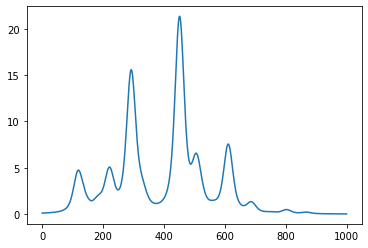

In [2]:
from crystal_out import crystalOut
import matplotlib.pyplot as plt
import numpy as np

def plot_spectra(output_file, sigma, gamma, wavenumber_range=(0,1000), resolution=1000):
    frequencies, convoluted_intensities = crystalOut(output_file).get_convoluted_spectra(sigma,gamma,wavenumber_range,resolution)
    plt.plot(frequencies, convoluted_intensities)
    axes = plt.gca()
    axes.set_xlabel("Wavenumber")
    axes.set_ylabel("Intensity (a.u.)")


plot_spectra("./crystal17_output_files/calc-Sb2O5_15_icsd1422_tzvp_PBE0/Sb2O5_15.out", 10, 10)

